In [1]:
# 从数据库中读取数据包
from pyspark.sql import SparkSession
import os
from pytoolkit import TDWSQLProvider
import pandas

In [2]:
# 从数据库中读取作者侧数据
os.environ['GROUP_ID'] = 'g_wxg_wxt_product_analytics_intern'
os.environ['GAIA_ID'] = '5729'
session = SparkSession.builder.config('spark.driver.maxResultSize','14g').config('spark.driver.memory', '14g').config('spark.executor.cores', 4).config('spark.executor.memory', '14g').config('spark.yarn.archive','hdfs://qy-ieg-4-v2/data/SPARK/cachefile/3_12_2.4.6_hadoop3/spark-jars_old_notauth.zip').getOrCreate()
tdw = TDWSQLProvider(session, group='tl', db='wxg_weixin_analytics_intern')
df=tdw.table('tmp_dws_app_bilateral_expt_13697038_finder_intern_uin_i').toPandas()
# tbl=tdw.table('tmp_dws_app_bilateral_expt13172784_finder_intern_uin_i')
# tbl.creatOrReplaceTempView('tbl')
# sql='''select * from tbl where ds='20220620' '''
# tbl1=session.sql(sql)

Driver Log: af85dd1a-3cb9-437a-8ef4-af82279f674c.log
Tracking URL: http://application.tdw.oa.com:8080/proxy/application_1664996746409_2423621


In [3]:
#数据分析包
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# 
from metric_funcs import Ttest, Metric
from frt_pvalue import sharp_null_hypothesis_pvalue

In [4]:
df.head(5)

,ds,groupid,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt,anonymous
0,20220718,308998,20220717,0.538749,5.238956,5.217426,8.012839,847ffe517a5423bc11172e7a4d8d638c
1,20220718,308998,20220707,0.538749,5.238956,5.217426,8.012839,9e41de3bfa644d45005dc91a8a1846a0
2,20220718,308998,20220709,0.538749,5.238956,5.217426,8.012839,0e4e12324c5a901aa3294ddbc36285ca
3,20220718,308999,20220707,0.538749,5.238956,5.217426,8.012839,0d4aa2b3910dbda7e96a807c79e4285e
4,20220718,308998,20220717,0.538749,5.238956,5.217426,8.012839,7e4042e6e46bf15555668bc8d4085cf1


# 数据分析

## 1. initial data exploration

In [5]:
df.head(5)

,ds,groupid,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt,anonymous
0,20220718,308998,20220717,0.538749,5.238956,5.217426,8.012839,847ffe517a5423bc11172e7a4d8d638c
1,20220718,308998,20220707,0.538749,5.238956,5.217426,8.012839,9e41de3bfa644d45005dc91a8a1846a0
2,20220718,308998,20220709,0.538749,5.238956,5.217426,8.012839,0e4e12324c5a901aa3294ddbc36285ca
3,20220718,308999,20220707,0.538749,5.238956,5.217426,8.012839,0d4aa2b3910dbda7e96a807c79e4285e
4,20220718,308998,20220717,0.538749,5.238956,5.217426,8.012839,7e4042e6e46bf15555668bc8d4085cf1


In [6]:
df.dtypes

ds                   object
groupid               int64
first_hit_ds          int64
feed_cnt_hot_100    float64
feed_cnt_hot_5k     float64
feed_cnt            float64
post_cnt            float64
anonymous            object
dtype: object

numerical variable：
feed_cnt_hot_100: 24小时内曝光达到100的feed
feed_cnt_hot_5k: 24小时内曝光达到5000的feed
feed_cnt: 当天冷启的feed数
post_cnt: 当天发表的全部视频数
    
catgorical variable:
anonymous: user nuique id
ds: date
first_hit_ds: 首次命中的日期
group_id: 是哪个实验组

In [7]:
numerical_col=["feed_cnt_hot_100","feed_cnt_hot_5k","feed_cnt","post_cnt"]
categorical_col=["anonymous","ds","first_hit_ds","groupid"]

## 2.Univariate Analysis

### 2.1 orginal data

In [8]:
# Univariate statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

output=unistats(df)
output.to_excel("f_univariate_statistics.xls")

In [9]:
output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,795958,0,397979,object,False,-,-,-,-,-,-,-,-,-
ds,795958,0,2,object,False,-,-,-,-,-,-,-,-,-
first_hit_ds,795958,0,12,int64,True,-,-,-,-,-,-,-,-,-
groupid,795958,0,2,int64,True,-,-,-,-,-,-,-,-,-
feed_cnt_hot_100,795958,0,24,float64,True,1.291365,0.538749,0.538749,0.538749,0.538749,394.506313,3.034792,12.203146,677.556309
feed_cnt_hot_5k,795958,0,17,float64,True,5.246885,5.238956,5.238956,5.238956,5.238956,59.726153,0.255151,79.853839,10417.012387
feed_cnt,795958,0,47,float64,True,6.384703,5.217426,5.217426,5.217426,5.217426,805.030707,4.284567,26.812339,2744.103868
post_cnt,795958,0,55,float64,True,9.568752,8.012839,8.012839,8.012839,8.012839,5800.331618,11.069911,358.773013,179555.656652


### 2.2 restore real data

#### restore numerical data

In [10]:
# copy data
new_df=df

In [11]:
# (1) -min (suppose min= 0)
for col in numerical_col:
    print(col,np.sort(df[col].unique())[0:2])

feed_cnt_hot_100 [0.53874948 8.11504877]
feed_cnt_hot_5k [5.23895551 8.10670273]
feed_cnt [ 5.21742611 11.88253678]
post_cnt [ 8.01283917 16.45645255]


In [12]:
for col in numerical_col:
    B= np.sort(df[col].unique())[0]
    A= np.sort(df[col].unique())[1]-np.sort(df[col].unique())[0]
    print(col,B,A)
    new_df[col]=(df[col]-B)/A
    print(col,np.sort(new_df[col].unique())[0:2])

feed_cnt_hot_100 0.5387494795548708 7.576299292959432
feed_cnt_hot_100 [0. 1.]
feed_cnt_hot_5k 5.238955514683797 2.867747218983295
feed_cnt_hot_5k [0. 1.]
feed_cnt 5.217426109601401 6.665110675123083
feed_cnt [0. 1.]
post_cnt 8.012839167331943 8.44361338086581
post_cnt [0. 1.]


In [13]:
np.round(new_df.describe(),3)

,groupid,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt
count,795958.0,7.959580e+05,795958.000,795958.000,795958.000,795958.000
mean,308998.5,2.022071e+07,0.099,0.003,0.175,0.184
std,0.5,3.477000e+00,0.401,0.089,0.643,1.311
min,308998.0,2.022071e+07,0.000,0.000,0.000,0.000
25%,308998.0,2.022071e+07,0.000,0.000,0.000,0.000
50%,308998.0,2.022071e+07,0.000,0.000,0.000,0.000
75%,308999.0,2.022072e+07,0.000,0.000,0.000,0.000
max,308999.0,2.022072e+07,52.000,19.000,120.000,686.000


In [14]:
# check new data
for col in numerical_col:
    print(np.sort(new_df[col].unique())[0:15])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


#### restore categorical data

### 2.3 cleaning data

In [15]:
# check first_hit_ds
new_df["in_experiment"]=np.where(pd.to_numeric(new_df["ds"])>new_df["first_hit_ds"],1,0)

In [16]:
new_df["in_experiment"].value_counts()

1    723611
0     72347
Name: in_experiment, dtype: int64

In [17]:
numerical_col=["feed_cnt_hot_100","feed_cnt_hot_5k","feed_cnt","post_cnt"]
categorical_col=["anonymous","ds","first_hit_ds","groupid","in_experiment"]

### 2.4 univariate analysis

#### statistics analysis

In [18]:
# statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

new_df_output=unistats(new_df)
new_df_output.to_excel("f_new_univariate_statistics.xls")

In [19]:
new_df_output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,795958,0,397979,object,False,-,-,-,-,-,-,-,-,-
ds,795958,0,2,object,False,-,-,-,-,-,-,-,-,-
first_hit_ds,795958,0,12,int64,True,-,-,-,-,-,-,-,-,-
groupid,795958,0,2,int64,True,-,-,-,-,-,-,-,-,-
in_experiment,795958,0,2,int64,True,-,-,-,-,-,-,-,-,-
feed_cnt_hot_100,795958,0,24,float64,True,0.099338,0.0,0.0,0.0,0.0,52.0,0.400564,12.203146,677.556309
feed_cnt_hot_5k,795958,0,17,float64,True,0.002765,0.0,0.0,0.0,0.0,19.0,0.088973,79.853839,10417.012387
feed_cnt,795958,0,47,float64,True,0.175132,0.0,0.0,0.0,0.0,120.0,0.642835,26.812339,2744.103868
post_cnt,795958,0,55,float64,True,0.184271,0.0,0.0,0.0,0.0,686.0,1.31104,358.773013,179555.656652


In [20]:
# categorical--statistics
for col in categorical_col[1:len(categorical_col)]:
    print(new_df[col].value_counts())

20220718    397979
20220717    397979
Name: ds, dtype: int64
20220707    101546
20220708     86664
20220709     83674
20220710     80052
20220711     64838
20220713     57822
20220714     56990
20220712     56082
20220715     54446
20220716     54396
20220717     54202
20220718     45246
Name: first_hit_ds, dtype: int64
308998    398182
308999    397776
Name: groupid, dtype: int64
1    723611
0     72347
Name: in_experiment, dtype: int64


#### visualization analysis

array([[<AxesSubplot:title={'center':'groupid'}>,
        <AxesSubplot:title={'center':'first_hit_ds'}>,
        <AxesSubplot:title={'center':'feed_cnt_hot_100'}>],
       [<AxesSubplot:title={'center':'feed_cnt_hot_5k'}>,
        <AxesSubplot:title={'center':'feed_cnt'}>,
        <AxesSubplot:title={'center':'post_cnt'}>],
       [<AxesSubplot:title={'center':'in_experiment'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

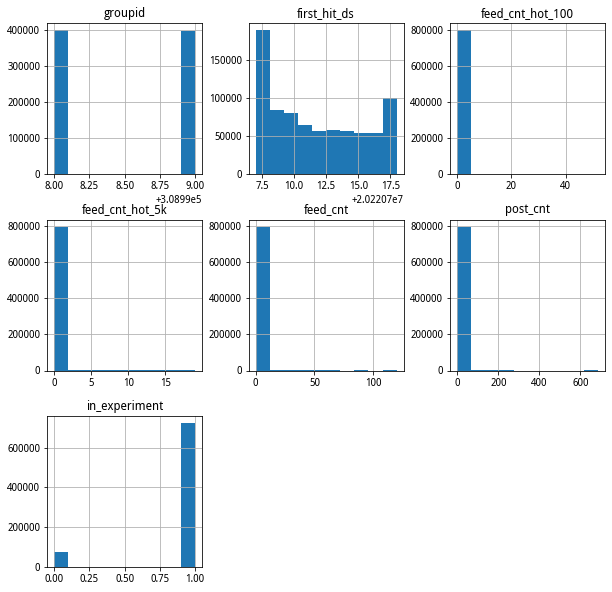

In [39]:
# # Univariate visualization(numerical variable)--histgram
new_df.hist(figsize=(10,10))

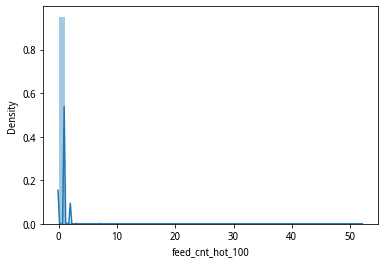

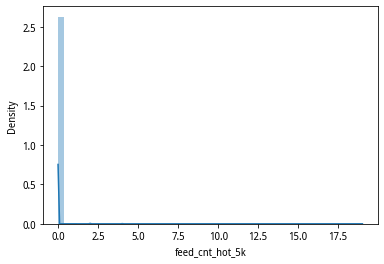

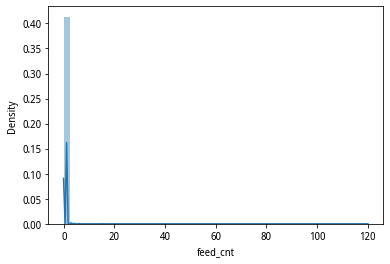

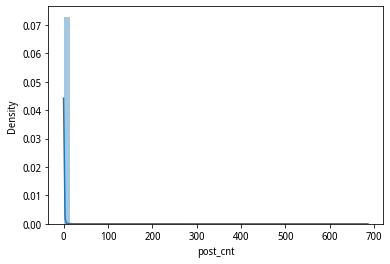

In [40]:
# # Univariate visualization(categorical variable)--brachart
for col in numerical_col:
    sns.distplot(new_df[col])
    plt.show()

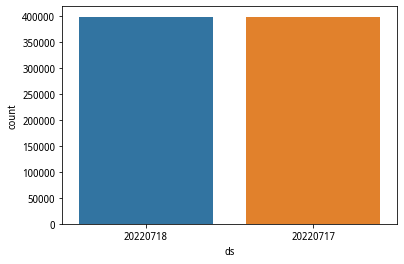

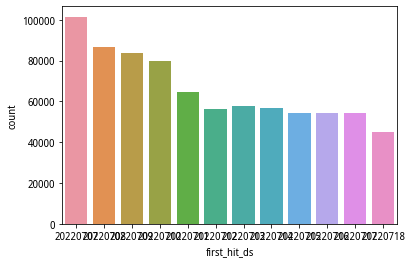

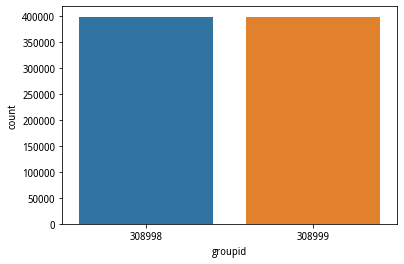

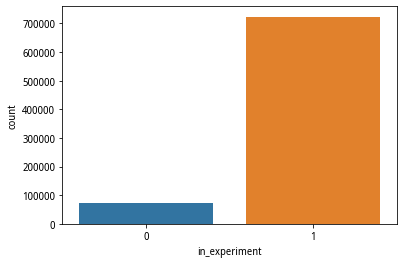

In [41]:
# # Univariate visualization(categorical variable)--brachart
for col in categorical_col[1:len(categorical_col)]:
    sns.countplot(new_df[col])
    plt.show()

conlusion:
1. panel data: individul: 397979, 2 period(0717-0718) , total data: 795958
2. first_hit_sd: 12 different joining days,(0707--0718)-- filter out (72347)
3. groupid: 308998 is control，308999 is treatment
4. for numerical variable: they all highly right skew, a lot of zeros.

## 3.Bivarite Analysis

In [21]:
# filter out 没参与实验的user
new_new_df= new_df

In [22]:
new_new_df.drop(new_new_df[new_new_df["in_experiment"]==0].index,inplace=True)

In [23]:
# statistics
def unistats(df):
    output_df=pd.DataFrame(columns=["count","Mising","Unique","Dtype","Numeric","Mean","Min","25%","Median","75%","Max","std","Skew","Kurt"])
    for col in categorical_col:
            output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                                '-','-','-','-','-','-','-','-','-']
    for col in numerical_col:
        output_df.loc[col]=[df[col].count(),df[col].isnull().sum(),len(df[col].unique()),df[col].dtype,pd.api.types.is_numeric_dtype(df[col]),
                               df[col].mean(),df[col].min(),df[col].quantile(0.25),df[col].median(),df[col].quantile(0.75),df[col].max(),df[col].std(),df[col].skew(),df[col].kurt()]
    return output_df

new_new_df_output=unistats(new_new_df)
new_new_df_output.to_excel("f_new_new_univariate_statistics.xls")

In [24]:
new_new_df_output

,count,Mising,Unique,Dtype,Numeric,Mean,Min,25%,Median,75%,Max,std,Skew,Kurt
anonymous,723611,0,375356,object,False,-,-,-,-,-,-,-,-,-
ds,723611,0,2,object,False,-,-,-,-,-,-,-,-,-
first_hit_ds,723611,0,11,int64,True,-,-,-,-,-,-,-,-,-
groupid,723611,0,2,int64,True,-,-,-,-,-,-,-,-,-
in_experiment,723611,0,1,int64,True,-,-,-,-,-,-,-,-,-
feed_cnt_hot_100,723611,0,22,float64,True,0.06544,0.0,0.0,0.0,0.0,52.0,0.349467,17.310822,1237.870702
feed_cnt_hot_5k,723611,0,17,float64,True,0.002492,0.0,0.0,0.0,0.0,19.0,0.085263,83.071294,11399.303458
feed_cnt,723611,0,43,float64,True,0.113231,0.0,0.0,0.0,0.0,120.0,0.564267,33.169093,4017.023397
post_cnt,723611,0,49,float64,True,0.119094,0.0,0.0,0.0,0.0,686.0,1.3162,388.990452,194457.355665


#### (1) numerical- numerical

##### correlation 

In [25]:
# (1) Numerical/Numerical
# numercial=4个
np.round(new_new_df[numerical_col].corr(),3)

,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt
feed_cnt_hot_100,1.000,0.376,0.735,0.314
feed_cnt_hot_5k,0.376,1.000,0.254,0.098
feed_cnt,0.735,0.254,1.000,0.581
post_cnt,0.314,0.098,0.581,1.000


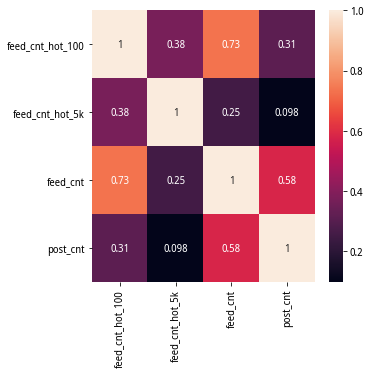

In [26]:
# 画correlation heat map图
plt.figure(figsize=(5,5))
sns.heatmap(np.round(new_new_df[numerical_col].corr(),3),annot=True)
plt.show()

##### visualization--scatterplot

<AxesSubplot:xlabel='post_cnt', ylabel='feed_cnt'>

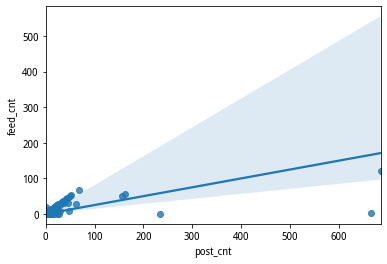

In [27]:
sns.regplot(new_new_df["post_cnt"],new_new_df["feed_cnt"])

<AxesSubplot:xlabel='post_cnt', ylabel='feed_cnt_hot_100'>

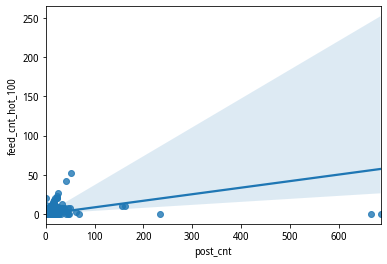

In [28]:
sns.regplot(new_new_df["post_cnt"],new_new_df["feed_cnt_hot_100"])

<AxesSubplot:xlabel='post_cnt', ylabel='feed_cnt_hot_5k'>

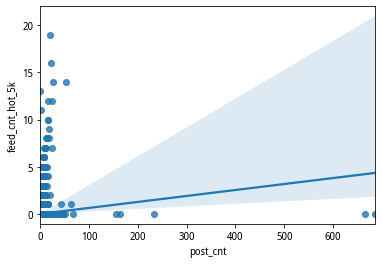

In [29]:
sns.regplot(new_new_df["post_cnt"],new_new_df["feed_cnt_hot_5k"])

<AxesSubplot:xlabel='feed_cnt', ylabel='feed_cnt_hot_100'>

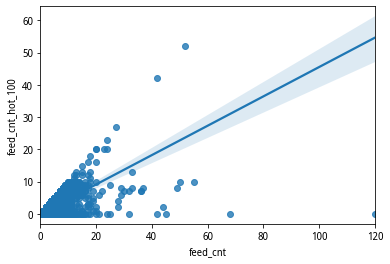

In [30]:
sns.regplot(new_new_df["feed_cnt"],new_new_df["feed_cnt_hot_100"])

<AxesSubplot:xlabel='feed_cnt', ylabel='feed_cnt_hot_5k'>

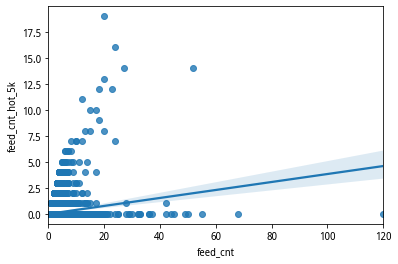

In [31]:
sns.regplot(new_new_df["feed_cnt"],new_new_df["feed_cnt_hot_5k"])

<AxesSubplot:xlabel='feed_cnt_hot_100', ylabel='feed_cnt_hot_5k'>

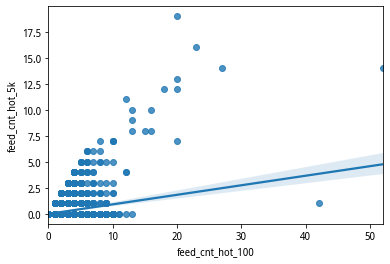

In [32]:
sns.regplot(new_new_df["feed_cnt_hot_100"],new_new_df["feed_cnt_hot_5k"])

In [34]:
# (2)Categorical/Numerical
# categorical = 看下日期和分组，分别的对不同nmuerical的影响
# # statistics--计算下ATE和p值
# 按照日期(一共有三天)
np.round(new_new_df.groupby(new_new_df["ds"]).mean(),3)

,groupid,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt,in_experiment
ds,,,,,,,
20220717,308998.5,2.022071e+07,0.067,0.003,0.117,0.123,1.0
20220718,308998.5,2.022071e+07,0.064,0.002,0.110,0.115,1.0


In [35]:
# 按照分组
np.round(new_new_df.groupby(new_new_df["groupid"]).mean(),3)

,first_hit_ds,feed_cnt_hot_100,feed_cnt_hot_5k,feed_cnt,post_cnt,in_experiment
groupid,,,,,,
308998,2.022071e+07,0.064,0.003,0.113,0.120,1.0
308999,2.022071e+07,0.067,0.002,0.113,0.118,1.0


In [36]:
# 按照分组
new_new_df.groupby([new_new_df["groupid"],new_new_df["ds"]]).mean()

first_hit_ds  feed_cnt_hot_100  feed_cnt_hot_5k  feed_cnt  \
groupid ds                                                                    
308998  20220717  2.022071e+07          0.065350         0.002720  0.115875   
        20220718  2.022071e+07          0.063271         0.002699  0.110596   
308999  20220717  2.022071e+07          0.067687         0.002345  0.118163   
        20220718  2.022071e+07          0.065611         0.002208  0.108836   

                  post_cnt  in_experiment  
groupid ds                                 
308998  20220717  0.121641            1.0  
        20220718  0.118284            1.0  
308999  20220717  0.125159            1.0  
        20220718  0.111913            1.0

In [38]:
# 按照分组
treatment_effect= np.round(new_new_df.groupby([new_new_df["groupid"],new_new_df["ds"]]).mean(),3)
treatment_effect.to_excel("f_treatment_effect.xls")

In [39]:
treatment_effect

first_hit_ds  feed_cnt_hot_100  feed_cnt_hot_5k  feed_cnt  \
groupid ds                                                                    
308998  20220717  2.022071e+07             0.065            0.003     0.116   
        20220718  2.022071e+07             0.063            0.003     0.111   
308999  20220717  2.022071e+07             0.068            0.002     0.118   
        20220718  2.022071e+07             0.066            0.002     0.109   

                  post_cnt  in_experiment  
groupid ds                                 
308998  20220717     0.122            1.0  
        20220718     0.118            1.0  
308999  20220717     0.125            1.0  
        20220718     0.112            1.0

In [40]:
# 计算P值
for col in numerical_col:
    content_c=(new_new_df.where(new_new_df.groupid==308998)[col].dropna()).tolist()
    count_c=[1 for _ in range(len(content_c))]
    content_t2=(new_new_df.where(new_new_df.groupid==308999)[col].dropna()).tolist()
    count_t2=[1 for _ in range(len(content_t2))]
    M_c=Metric(content_c,count_c)
    M_t=Metric(content_t2,count_t2)
    p= Ttest(M_c,M_t).pvalue()
    print(col,p)

feed_cnt_hot_100 0.004426542598258365
feed_cnt_hot_5k 0.029931200989982587
feed_cnt 0.8873502540608968
post_cnt 0.6023431254228278


<AxesSubplot:xlabel='groupid', ylabel='feed_cnt'>

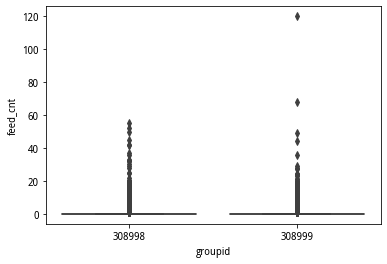

In [51]:
# # Visualization --箱线图
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["feed_cnt"])

<AxesSubplot:xlabel='groupid', ylabel='post_cnt'>

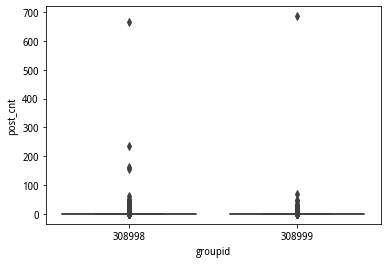

In [52]:
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["post_cnt"])

<AxesSubplot:xlabel='groupid', ylabel='feed_cnt_hot_100'>

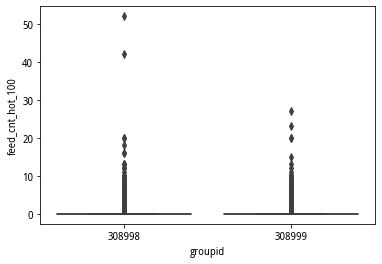

In [55]:
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["feed_cnt_hot_100"])

<AxesSubplot:xlabel='groupid', ylabel='feed_cnt_hot_5k'>

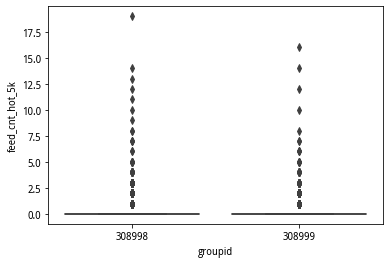

In [56]:
sns.boxplot(x=new_new_df["groupid"],y=new_new_df["feed_cnt_hot_5k"])